# Analyzing and visualizing

## Molecular structure

Molecular structures can be inspected with use of the `py3Dmol` module. We initialize a view and include a stick representation of the water molecule. The view is interactive, so you can rotate, translate, zoom in and out. An illustration of the van der Waals surface is added to give an idea of the "molecular size", or the electron cloud.

In [1]:
import veloxchem as vlx

h2o_xyz = """3
water molecule                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                       
H    0.740848095288        0.582094932012        0.000000000000                         
H   -0.740848095288        0.582094932012        0.000000000000
"""
molecule = vlx.Molecule.from_xyz_string(h2o_xyz)

basis = vlx.MolecularBasis.read(molecule, "cc-pVDZ")

scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Info * Reading basis set from file: /opt/miniconda3/envs/echem/lib/python3.9/site-packages/veloxchem/basis/CC-PVDZ      
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                                  Basis: CC-PVDZ                                                                          
                                                                                                                          
                                  Atom Contracted GTOs          Primitive GTOs                                            
                                       

In [2]:
import py3Dmol as p3d

v = p3d.view(width=300, height=300)

v.addModel(h2o_xyz, "xyz")
v.setStyle({'stick':{}})
v.addSurface(p3d.VDW,{'opacity': 0.7, 'color': 'green'})

v.zoomTo()

v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

(section-scf-info)=
## SCF information

The SCF driver object contains a wealth of useful information:

- The final SCF energy: `scf_drv.get_scf_energy()`
- A Python dictionary of tensors: `scf_drv.scf_tensors`
    - `C`: molecular orbital coefficients as a NumPy array
    - `E`: orbital energies as a NumPy array
    - `D`: $\alpha$- and $\beta$-spin density matrices as a tuple of NumPy arrays
    - `F`: $\alpha$- and $\beta$-spin Fock matrices as a tuple of NumPy arrays
    - `S`: overlap integrals as a NumPy array

In [3]:
print(f'Hartree–Fock energy: {scf_drv.get_scf_energy():14.10f} a.u.\n')

print('Dictionary keys:\n', scf_drv.scf_tensors.keys(), '\n')

print('Orbital energies:\n', scf_drv.scf_tensors['E'])

Hartree–Fock energy: -76.0269841873 a.u.

Dictionary keys:
 dict_keys(['S', 'C_alpha', 'C_beta', 'E_alpha', 'E_beta', 'D_alpha', 'D_beta', 'F_alpha', 'F_beta', 'C', 'E', 'D', 'F']) 

Orbital energies:
 [-20.54818972  -1.345205    -0.70584505  -0.57108597  -0.49456798
   0.18786924   0.2585202    0.79748539   0.87271166   1.16315036
   1.20011488   1.25334062   1.43477498   1.48313855   1.67303123
   1.86242483   1.95691981   2.48659724   2.53078557   3.30367059
   3.35068938   3.53410961   3.87596599   4.16973921]


(section-orbitals)=
## Molecular orbitals

The values of orbitals at given coordinates are readily available. Below is an example in terms of finding the values of the $1s$-orbital ($\alpha$-spin) along the $z$-axis. 

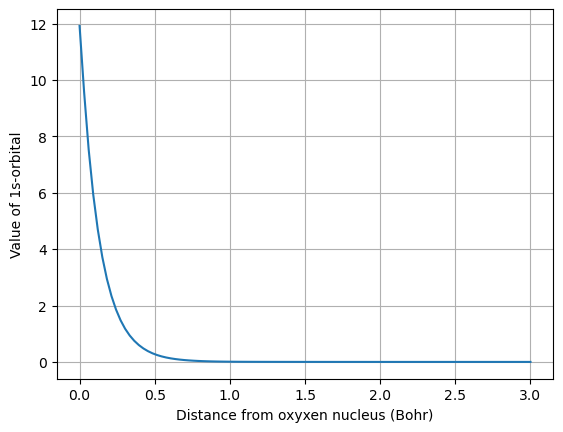

In [4]:
import numpy as np
import matplotlib.pyplot as plt

vis_drv = vlx.VisualizationDriver()
mol_orbs = scf_drv.mol_orbs

n = 100
coords = np.zeros((n,3))
coords[:,2] = np.linspace(0,3,n)

mo_1s = 0 
mo_1s_values = vis_drv.get_mo(coords, molecule, basis, mol_orbs, mo_1s, 'alpha')

plt.plot(coords[:,2], mo_1s_values)

plt.grid(True)
plt.xlabel('Distance from oxyxen nucleus (Bohr)')
plt.ylabel('Value of 1s-orbital')

plt.show()

## One-particle density

The one-particle density for an $N$-electron system is defined as

$$
    n(\mathbf{r}) = N \int 
    \Psi^\dagger(\mathbf{r}, \mathbf{r}_2, \ldots,\mathbf{r}_N)
    \Psi(\mathbf{r}, \mathbf{r}_2, \ldots,\mathbf{r}_N)
    \, d^3\mathbf{r}_2 \cdots d^3\mathbf{r}_N
$$

and it refers to the probability density of finding any one electron at position $\mathbf{r}$ in space regardless of the distribution of others. It fulfills

$$
     \int n(\mathbf{r}) \, d^3\mathbf{r} = N
$$

For a Hartree–Fock state, one-particle densities are available as illustrated in the example script below.

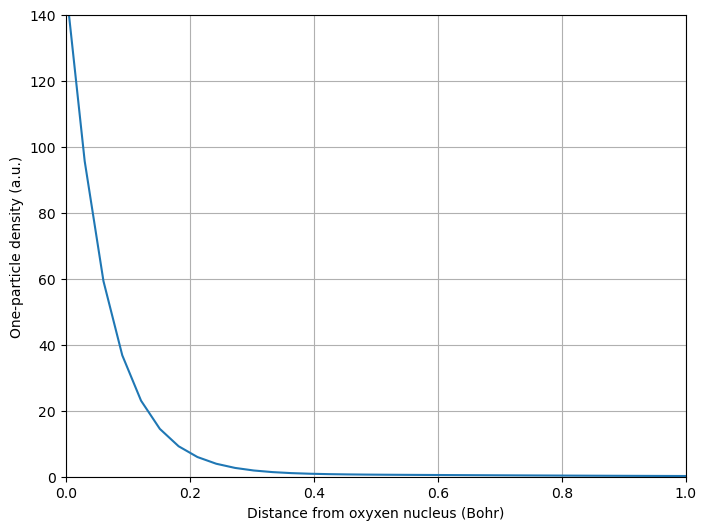

In [5]:
vis_drv = vlx.VisualizationDriver()

one_part_den = vis_drv.get_density(coords, molecule, basis, scf_drv.density, 'alpha')

fig = plt.figure(figsize = (8,6))
ax = plt.axes(xlim = (0,1), ylim = (0,140))

plt.plot(coords[:,2], one_part_den)

plt.grid(True)
plt.xlabel('Distance from oxyxen nucleus (Bohr)')
plt.ylabel('One-particle density (a.u.)')

plt.show()

As indicated by the string argument "alpha", the $\alpha$- and $\beta$-spin densities can be determined individually, referring to the relation

$$
    n(\mathbf{r}) = n^\alpha(\mathbf{r}) + n^\beta(\mathbf{r})
$$

For a closed shell system, the two spin densities are equal and thus equal to half the total one-particle density.

In [6]:
help(vis_drv.get_density)

Help on method get_density in module veloxchem.veloxchemlib:

get_density(...) method of veloxchem.veloxchemlib.VisualizationDriver instance
    get_density(self: veloxchem.veloxchemlib.VisualizationDriver, coords: List[List[float]], molecule: veloxchem.veloxchemlib.Molecule, basis: veloxchem.veloxchemlib.MolecularBasis, density: veloxchem.veloxchemlib.AODensityMatrix, denspin: str) -> List[float]
    
    Computes densities at given coordinates.



## Two-particle density

The two-particle density for an $N$-electron system is defined as

$$
   n(\mathbf{r}_1, \mathbf{r}_2) = N(N-1)\int 
    \Psi^\dagger(\mathbf{r}_1, \mathbf{r}_2, \ldots,\mathbf{r}_N)
    \Psi(\mathbf{r}_1, \mathbf{r}_2, \ldots,\mathbf{r}_N)
    \, d^3\mathbf{r}_3 \cdots d^3\mathbf{r}_N
$$

and it refers to the probability density of finding one electron at position $\mathbf{r}_1$ and another at position $\mathbf{r}_2$ in space regardless of the distribution of others.

For a Hartree–Fock state, two particle densities are available as illustrated in the example script below.

In [8]:
coord = [[0.0, 0.0, 0.0]]

two_part_den_aa = vis_drv.get_two_particle_density(coord, coord, molecule, basis,
                                               scf_drv.density, 'alpha', 'alpha')
two_part_den_ab = vis_drv.get_two_particle_density(coord, coord, molecule, basis,
                                               scf_drv.density, 'alpha', 'beta')

print(f'Two-particle density     (same spin): {two_part_den_aa[0]:10.4f} a.u.')
print(f'Two-particle density (opposite spin): {two_part_den_ab[0]:10.4f} a.u.')

Two-particle density     (same spin):     0.0000 a.u.
Two-particle density (opposite spin): 22079.6216 a.u.


As indicated by the string arguments "alpha" and "beta", the spin densities can be determined individually, referring to the relation

$$
    n(\mathbf{r}_1, \mathbf{r}_2) = n^{\alpha\alpha}(\mathbf{r}_1, \mathbf{r}_2) + 
    n^{\alpha\beta}(\mathbf{r}_1, \mathbf{r}_2) + n^{\beta\alpha}(\mathbf{r}_1, \mathbf{r}_2) + 
    n^{\beta\beta}(\mathbf{r}_1, \mathbf{r}_2)
$$

For a closed shell system, we have

\begin{align*}
n^{\alpha\alpha}(\mathbf{r}_1, \mathbf{r}_2) & = n^{\beta\beta}(\mathbf{r}_1, \mathbf{r}_2) \\
n^{\alpha\beta}(\mathbf{r}_1, \mathbf{r}_2) & = n^{\beta\alpha}(\mathbf{r}_1, \mathbf{r}_2) 
\end{align*}

In [ ]:
help(vis_drv.get_two_particle_density)